# Submission Information:

### Team Member 1:
* UNI: kc3057 
* Name: Kaavya Chinniah

### Team Member 2 [optional]:
* UNI: as5196
* Name: Amla Srivastava

# Step0 - Import Libraries, Load Data [0 points]

This is the basic step where you can load the data and create train and test sets for internal validation as per your convinience.

In [1663]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.rcParams["figure.dpi"] = 100
np.set_printoptions(precision=3, suppress=True)
import pandas as pd

##### Importing the Data file as pandas dataframe

In [1664]:
df = pd.read_csv("data/data.csv")

In [1665]:
df.head()

,age,job,marital_status,education,credit_default,housing,loan,contact,month,day_of_week,...,campaign,prev_days,prev_contacts,prev_outcomes,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,subscribed
0,41.0,blue-collar,married,basic.9y,no,yes,no,cellular,apr,mon,...,2.0,999,0,nonexistent,-1.695118,92.698705,-46.727552,1.345160,5097.0,no
1,46.0,entrepreneur,married,unknown,no,no,no,cellular,may,wed,...,2.0,999,0,nonexistent,-1.767159,92.914878,-46.313088,1.314499,5100.0,no
2,56.0,unemployed,married,basic.9y,no,yes,yes,cellular,nov,fri,...,1.0,999,0,nonexistent,-0.100365,93.423076,-41.904559,4.003471,5193.0,no
3,89.0,retired,divorced,basic.4y,no,yes,no,cellular,may,wed,...,4.0,999,0,nonexistent,-1.771314,93.672814,-46.045500,1.261668,5100.0,no
4,34.0,entrepreneur,married,university.degree,unknown,yes,no,cellular,jul,thu,...,8.0,999,0,nonexistent,1.458103,94.296285,-42.455877,5.152077,5233.0,no


# Step1 - Exploration and Preparation [10 points]

In this step, we expect you to look into the data and try to understand it before modeling. This understanding may lead to some basic data preparation steps which are common across the two model sets required.

##### Dropping the Duration column

The duration column was dropped from the dataset as only features available before making the promotional call are to be used. 

In [1666]:
df=df.drop("duration",axis=1)

In [1907]:
df_old=df

In [1908]:
df_old.shape

(32950, 20)

##### Frequency table for the target variable

In [1769]:
pd.crosstab(index=df["subscribed"],  
                      columns="count")      

col_0,count
subscribed,
no,29238
yes,3712


**Note:** Here, we see that the class distribution is **unbalanced** with nearly **12.7%** of the data with *Subscribed="Yes"* and the *remaining as Subscribed="No"*. Therefore, in our models we have used **parameter class_weight as balanced** to account for this variation.

# Step2 - ModelSet1 [35 points]

In this step, we expect you to perform the following steps relevant to the models you choose for set1:

* feature engineering
* validation
* feature selection
* final model selection

You may select up to 5 models in this step for the purpose of final ensemble. Any classification algorithm covered in class apart from tree-based models can be tested here.

### Feature Engineering: Creating Bins for Variables

##### Creating bin for age group

We found that records were uniformly distributed across certain age groups, hence we created bins for age accordingly as a new feature.

In [1432]:
bins = [0, 19, 27, 43, 61,100]
group_names = ['<=19', '20-27', '28-43', '44-61','>=62']
# categories = pd.cut(df['age'], bins, labels=group_names)
df['age_group'] = pd.cut(df['age'], bins, labels=group_names)
df['age_group'].head()

0    28-43
1    44-61
2    44-61
3     >=62
4    28-43
Name: age_group, dtype: category
Categories (5, object): [<=19 < 20-27 < 28-43 < 44-61 < >=62]

##### Creating bins for quarter

Certain feature values were reported by quarter. Since dates were a categorical feature there was no way for the model to know which quarter a certain promotional call was made in so as to correlate with other features. Hence we created a new column to indicate quarter for every call.

In [1433]:
for i in range(0,len(df)):
    s = 'Unknown'
    if df.iloc[i]['month'] in ['jan','feb','mar']:
        s = 'Q1'
        
    elif df.iloc[i]['month'] in ['apr','may','jun']:
        s = 'Q2'
        
    elif df.iloc[i]['month'] in ['jul','aug','sep']:
        s = 'Q3'
        
    elif df.iloc[i]['month'] in ['oct','nov','dec']:
        s = 'Q4'
        
    df.set_value(i,'quarter',s)

In [1434]:
df.shape

(32950, 22)

##### Creating indicator for prev_days as 0 for 999 unknown and 1 for the rest

prev_days is a continuous feature with a range of 0 - 27. If no call has been made previously in the same campaign, it is represented by value 999. There was no logical way to impute this variable since it encodes a different kind of information. To deal with this we created an extra indicator column to indicate if a value for prev_days exists or not.

In [1623]:
df['prev_days_ind'] = np.where(df['prev_days']==999, 0, 1)

In [1668]:
df.shape


(32950, 20)

##### Separating target variable from the data

The target variable 'subscribed' in the form of 'yes' and 'no' was removed from the dataset to create a separate column. 'yes' was replaced by 1 and 'no' by 0.

In [1909]:
df_sub = pd.get_dummies(df_old['subscribed'])
df_new=pd.concat([df_old, df_sub], axis=1)

In [1910]:
df_new=df_new.drop("subscribed", axis=1)
df_new=df_new.drop("no", axis=1)
df_new["yes"]=df_new["yes"].apply(int)

In [1911]:
df_new = df_new.rename(columns={'yes': 'subscribed'})

In [1912]:
df_new

,age,job,marital_status,education,credit_default,housing,loan,contact,month,day_of_week,campaign,prev_days,prev_contacts,prev_outcomes,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,subscribed
0,41.0,blue-collar,married,basic.9y,no,yes,no,cellular,apr,mon,2.0,999,0,nonexistent,-1.695118,92.698705,-46.727552,1.345160,5097.0,0
1,46.0,entrepreneur,married,unknown,no,no,no,cellular,may,wed,2.0,999,0,nonexistent,-1.767159,92.914878,-46.313088,1.314499,5100.0,0
2,56.0,unemployed,married,basic.9y,no,yes,yes,cellular,nov,fri,1.0,999,0,nonexistent,-0.100365,93.423076,-41.904559,4.003471,5193.0,0
3,89.0,retired,divorced,basic.4y,no,yes,no,cellular,may,wed,4.0,999,0,nonexistent,-1.771314,93.672814,-46.045500,1.261668,5100.0,0
4,34.0,entrepreneur,married,university.degree,unknown,yes,no,cellular,jul,thu,8.0,999,0,nonexistent,1.458103,94.296285,-42.455877,5.152077,5233.0,0
5,33.0,technician,married,basic.6y,no,no,no,telephone,jun,mon,3.0,999,0,nonexistent,1.498926,97.710487,-42.994167,5.017193,5231.0,0
6,38.0,services,married,high.school,unknown,yes,no,telephone,jul,mon,3.0,999,0,nonexistent,1.486893,93.501526,-42.901180,4.908002,5226.0,0
7,45.0,management,married,high.school,no,yes,no,cellular,nov,wed,1.0,999,0,nonexistent,0.013151,95.912371,-41.597353,4.145364,5192.0,0
8,23.0,admin.,married,high.school,no,no,no,cellular,jul,mon,4.0,999,0,nonexistent,1.464003,93.167350,-42.664099,4.929027,5232.0,0
9,35.0,management,married,university.degree,no,yes,yes,cellular,jul,fri,1.0,999,0,nonexistent,1.487322,95.122060,-42.143714,4.866617,5236.0,0


In [1913]:
y=df_new.subscribed
X_drop=df_new.drop("subscribed", axis=1)

In [1914]:
X_drop.shape

(32950, 19)

##### Selecting categorical features and creating dummies

Since there were several categorical features in the dataset, these were replaced by dummy variables to encode them correctly.

In [1915]:
cat_col=["job","marital_status","education","credit_default","housing","loan","contact","month","day_of_week","prev_outcomes"]

In [1916]:
# cat_col=["job","marital_status","education","credit_default","housing","loan","contact","month","day_of_week","prev_outcomes","quarter","age_group"]

In [1917]:
X = pd.get_dummies(X_drop, columns = cat_col)
X.shape

(32950, 62)

In [1918]:
X

,age,campaign,prev_days,prev_contacts,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,job_admin.,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,prev_outcomes_failure,prev_outcomes_nonexistent,prev_outcomes_success
0,41.0,2.0,999,0,-1.695118,92.698705,-46.727552,1.345160,5097.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,46.0,2.0,999,0,-1.767159,92.914878,-46.313088,1.314499,5100.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,56.0,1.0,999,0,-0.100365,93.423076,-41.904559,4.003471,5193.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,89.0,4.0,999,0,-1.771314,93.672814,-46.045500,1.261668,5100.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,34.0,8.0,999,0,1.458103,94.296285,-42.455877,5.152077,5233.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5,33.0,3.0,999,0,1.498926,97.710487,-42.994167,5.017193,5231.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
6,38.0,3.0,999,0,1.486893,93.501526,-42.901180,4.908002,5226.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7,45.0,1.0,999,0,0.013151,95.912371,-41.597353,4.145364,5192.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
8,23.0,4.0,999,0,1.464003,93.167350,-42.664099,4.929027,5232.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
9,35.0,1.0,999,0,1.487322,95.122060,-42.143714,4.866617,5236.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Feature Selection

Several feature selection techniques were tried on the dataset. Mutual info regression and f-regression indicated that 
nr_employed, prev_days, euribor3m, prev_outcomes, prev_contacts seemed to be the top most important variables. Other methods such as SelectFromModel using logistic regresson, Linear SVC and Tree-based methods were also tried. Final models were trained and evaluated on both selected features and the entire dataset. Since feature selection did not give any improvement in accuracy and there were only 62 features in the dataset, all features were retained.

##### Method 1: Mutual info classification

In [1924]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, stratify=y)

In [1923]:
from sklearn.feature_selection import mutual_info_classif
mi = mutual_info_classif(X_train, y_train)

In [1920]:
inds = np.argsort(mi)

(0, 72)

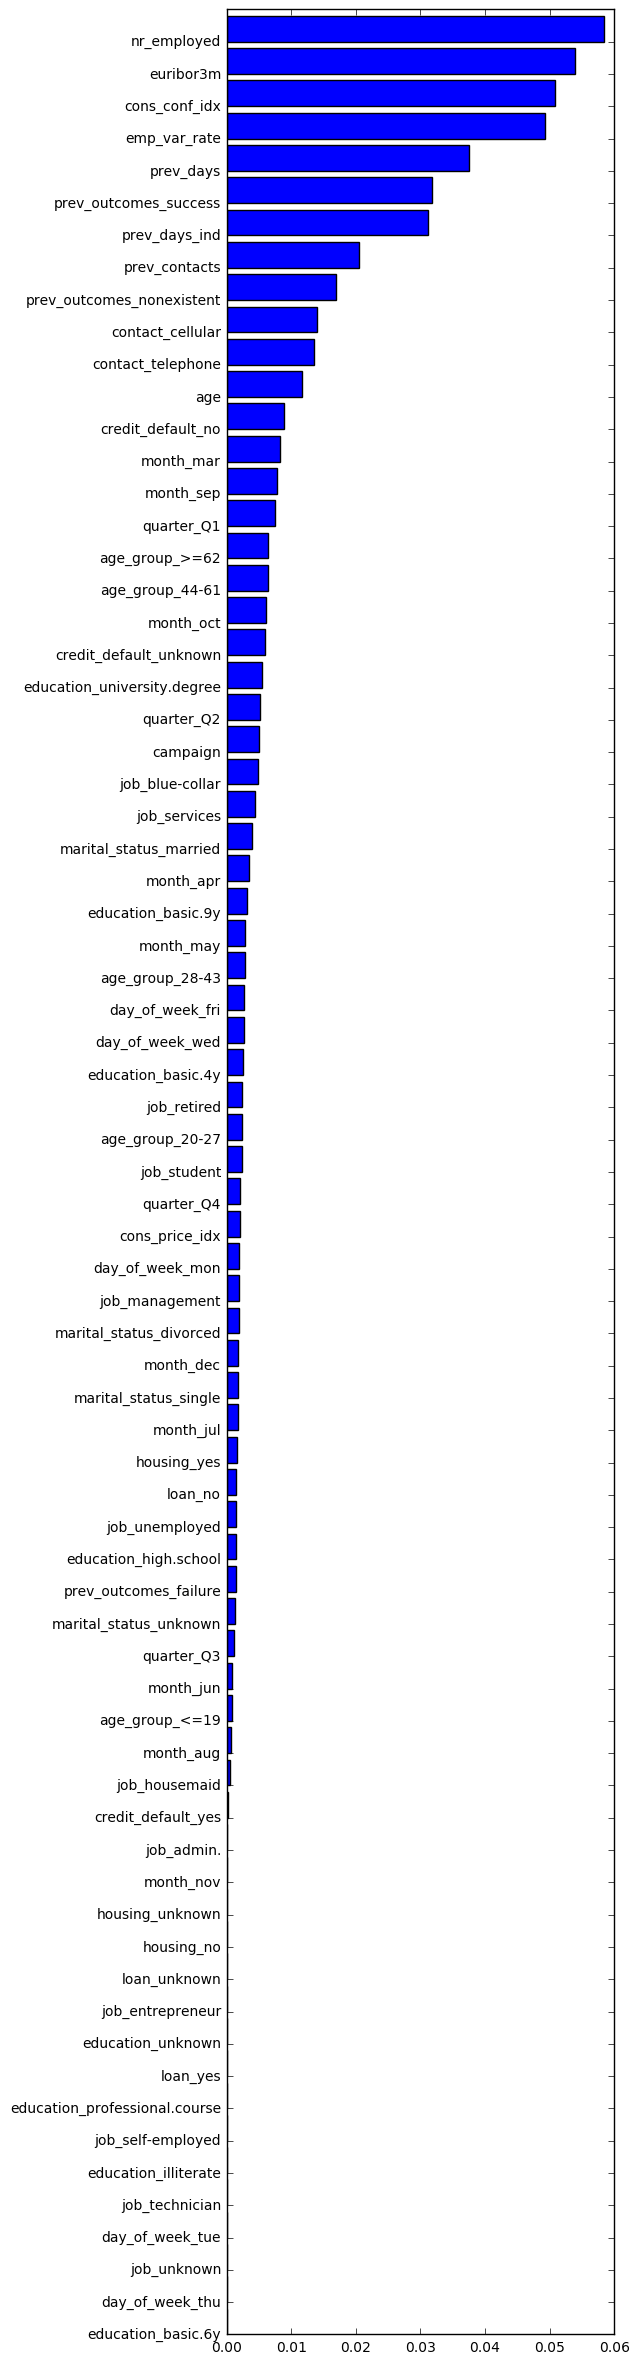

In [468]:
plt.figure(figsize=(5, 30))
plt.barh(np.arange(len(mi)), np.log(mi[inds] + 1))
plt.yticks(np.arange(len(mi)), X_train.columns[inds])
plt.ylim(0, len(mi))

##### Method 2: F- Classification

(0, 34)

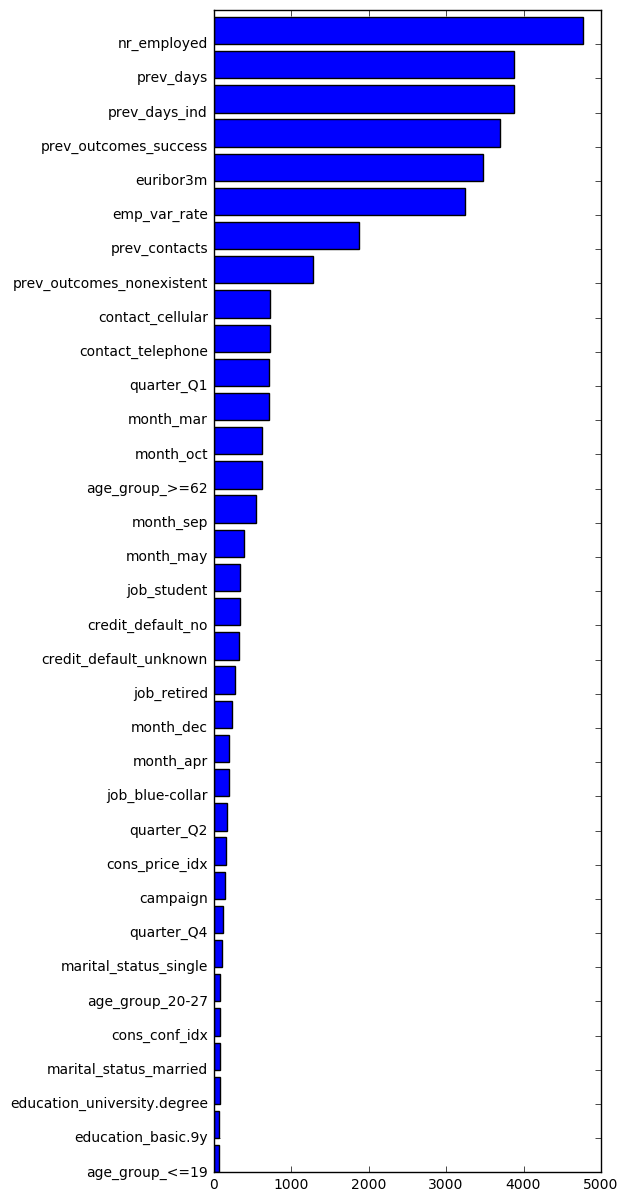

In [469]:
from sklearn.feature_selection import f_classif
F, p = f_classif(X, y)

top_n = 34
inds = np.argsort(F)
plt.figure(figsize=(5, 15))
plt.barh(np.arange(top_n), F[inds[-top_n:]])
plt.yticks(np.arange(top_n), X_train.columns[inds[-top_n:]])
plt.ylim(0, top_n)

In [93]:
sel_column=X.columns[inds[-top_n:]]
sel_column

Index(['day_of_week_mon', 'education_basic.6y', 'age', 'prev_outcomes_failure',
       'job_services', 'month_jul', 'job_admin.', 'education_basic.9y',
       'education_university.degree', 'marital_status_married',
       'cons_conf_idx', 'marital_status_single', 'campaign', 'cons_price_idx',
       'job_blue-collar', 'month_apr', 'month_dec', 'job_retired',
       'credit_default_unknown', 'credit_default_no', 'job_student',
       'month_may', 'month_sep', 'month_oct', 'month_mar', 'contact_cellular',
       'contact_telephone', 'prev_outcomes_nonexistent', 'prev_contacts',
       'emp_var_rate', 'euribor3m', 'prev_outcomes_success', 'prev_days',
       'nr_employed'],
      dtype='object')

In [144]:
X_f1=X[sel_column]

#####  Method 3: SelectFromModel
L1-based feature selection

**Logistic Regression**

In [272]:
from sklearn.linear_model import LogisticRegression  
from sklearn.feature_selection import SelectFromModel
X.shape

(32950, 62)

In [273]:
lsvc = LogisticRegression(C=1000, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
X_new.shape

(32950, 62)

**Linear SVC**

In [1677]:
from sklearn.svm import LinearSVC 
from sklearn.feature_selection import SelectFromModel
X.shape

(32950, 62)

In [1678]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
X_new.shape

(32950, 23)

##### Tree-based feature selection

In [554]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
X.shape

(32950, 72)

In [1774]:
clf = ExtraTreesClassifier()
clf = clf.fit(X, y) 

In [1775]:
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
X_new.shape 

(32950, 9)

### Transforming Input

##### Polynomial Features

Polynomial feature generation was tried but gave no improvement in final scores and hence was not used.

In [1228]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(include_bias=False,interaction_only=True)
X_bc_poly = poly.fit_transform(X)
print(X.shape)
print(X_bc_poly.shape)

(32950, 62)
(32950, 1953)


## Models 

### Logistic Regression

We performed logistic regression CV and C = 100 to get best ROC score. To account for unbalanced classes, we used class_weight = balanced. Pipelining was used for scaling (MinMaxScaler due to sparsity), PCA (for dimensionality reduction)

In [1832]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
# X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42,test_size=0.2)
# X_train, X_test, y_train, y_test = train_test_split(X_bc_poly, y,random_state=42,test_size=0.2)

X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y,random_state=0,test_size=0.15)
# X_train, X_test, y_train, y_test = train_test_split(X_bc_poly, y,random_state=42,test_size=0.2)

pipe = make_pipeline(MinMaxScaler(), PCA(n_components=50),LogisticRegressionCV(penalty='l2',Cs=100,class_weight = 'balanced')).fit(X_train, y_train)
pipe.fit(X_train, y_train)


pred_lr = pipe.predict_proba(X_test)
# pred = voting.predict(X_test)
print("")
print("ROC Score: {:.3f}".format(roc_auc_score(y_test, pred_lr[:,1])))


ROC Score: 0.818


CalibratedClassifierCV was used and gave good ROC AUC score. However, it could not be included in the Voting Classifier and thus was not used.

In [1735]:
from sklearn.calibration import CalibratedClassifierCV
cal_rf = CalibratedClassifierCV(pipe, cv="prefit", method='sigmoid')
cal_rf.fit(X_train, y_train)
scores_sigm = cal_rf.predict_proba(X_test)[:, 1]
print("ROC Score: {:.3f}".format(roc_auc_score(y_test, scores_sigm)))
cal_rf_iso = CalibratedClassifierCV(pipe, cv="prefit", method='isotonic')
cal_rf_iso.fit(X_train, y_train)
scores_iso = cal_rf_iso.predict_proba(X_test)[:, 1]
print("ROC Score: {:.3f}".format(roc_auc_score(y_test, scores_iso)))

ROC Score: 0.818
ROC Score: 0.817


### SGD Classifier

Stochastic Gradient Descent didn't give good results so was not included in the final ensemble.

In [1843]:
from sklearn.utils import gen_batches, shuffle
from sklearn.preprocessing import scale
from sklearn.linear_model import SGDClassifier
X_train, X_test, y_train, y_test = train_test_split(scale(X),
                                                    y, stratify=y)
batches = [(X_train[batch], y_train[batch]) for batch in gen_batches(X_train.shape[0], 5)]

sgd = SGDClassifier(loss='modified_huber')
for X_batch, y_batch in batches:
    sgd.partial_fit(X_batch, y_batch, classes=[0, 1])
sgd.score(X_test, y_test)

pred_lr = sgd.predict_proba(X_test)
# pred = voting.predict(X_test)
print("")
print("ROC Score: {:.3f}".format(roc_auc_score(y_test, pred_lr[:,1])))


ROC Score: 0.606


### KNN Classifier

Grid Search was used to determine the best no. of neighbors which came to 13. ROC AUC score was ...


In [1850]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

pipe = make_pipeline(MinMaxScaler(), KNeighborsClassifier())
param_grid = {'kneighborsclassifier__n_neighbors':  np.arange(1, 15, 2)}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=10, scoring = 'roc_auc')
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

pred_lr = grid.predict_proba(X_test)
print("")
print("ROC Score: {:.3f}".format(roc_auc_score(y_test, pred_lr[:,1])))

KeyboardInterrupt: 

### SVC with linear kernel

Support vector machines were run with different kernels like 'poly', 'rbf', 'sigmoid' and 'linear'. Linear kernel gave best results with class_weight as balanced.



In [1784]:
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y,test_size=0.15,random_state=0)
l_svc = SVC(kernel = 'linear', probability = True, class_weight = 'balanced', random_state = 42)
l_svc.fit(X_train,y_train)

print(l_svc.score(X_test,y_test))
pred = l_svc.predict_proba(X_test)
print("ROC Score: {:.3f}".format(roc_auc_score(y_test, pred[:,1])))

0.767752377099
ROC Score: 0.816


### Gaussian Naive-Bayes



In [1357]:
from sklearn.naive_bayes import GaussianNB
gnb=GaussianNB()
gnb.fit(X_train, y_train)
predictions = gnb.predict_proba(X_test)
# pred_rf = rf.predict_proba(X_test)
# pred = voting.predict(X_test)
print("ROC Score: {:.3f}".format(roc_auc_score(y_test, predictions[:, 1])))

ROC Score: 0.803


# Step3 - ModelSet2 [35 points]

In this step, we expect you to perform the following steps relevant to the models you choose for set2:

* feature engineering
* validation
* feature selection
* final model selection

You may select up to 5 models in this step for the purpose of final ensemble. We encourage you to try decition tree, random forest and gradient boosted tree methods here and pick the one which you think works best.

### Decision Tree Classifier

Grid Search was used to find best max_depth, min_samples_split an min_samples_leaf. ROC AUC score of 80.9 was observed.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = make_pipeline(DecisionTreeClassifier(class_weight = 'balanced'))
param_grid = {'decisiontreeclassifier__max_depth': np.arange(1,11,1),
              'decisiontreeclassifier__min_samples_split': np.arange(2,11,1),
              'decisiontreeclassifier__min_samples_leaf': np.arange(1,30,2)}
                   
grid = GridSearchCV(dt, param_grid, cv = 5, scoring = 'roc_auc')
grid.fit(X_train,y_train)

print(grid.score(X_test,y_test))
print(grid.best_params_)

pred = grid.predict_proba(X_test)
print("ROC Score: {:.3f}".format(roc_auc_score(y_test, pred[:,1])))

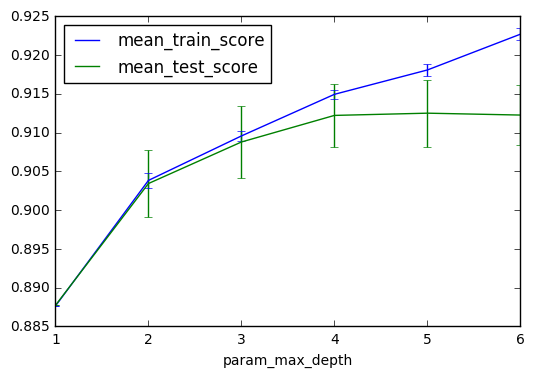

In [79]:
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
param_grid = {'max_depth':range(1, 7)}
grid = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid=param_grid, cv=StratifiedShuffleSplit(100))
grid.fit(X_train, y_train)

scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_max_depth', y='mean_train_score', yerr='std_train_score', ax=plt.gca())
scores.plot(x='param_max_depth', y='mean_test_score', yerr='std_test_score', ax=plt.gca())

For trees we looked feature importances to see if similar features were selected as indicated by initial feature selection scores.

In [391]:
tree = DecisionTreeClassifier(max_depth=3).fit(X_train, y_train)

([<matplotlib.axis.YTick at 0x116c7a940>,
 <a list of 62 Text yticklabel objects>)

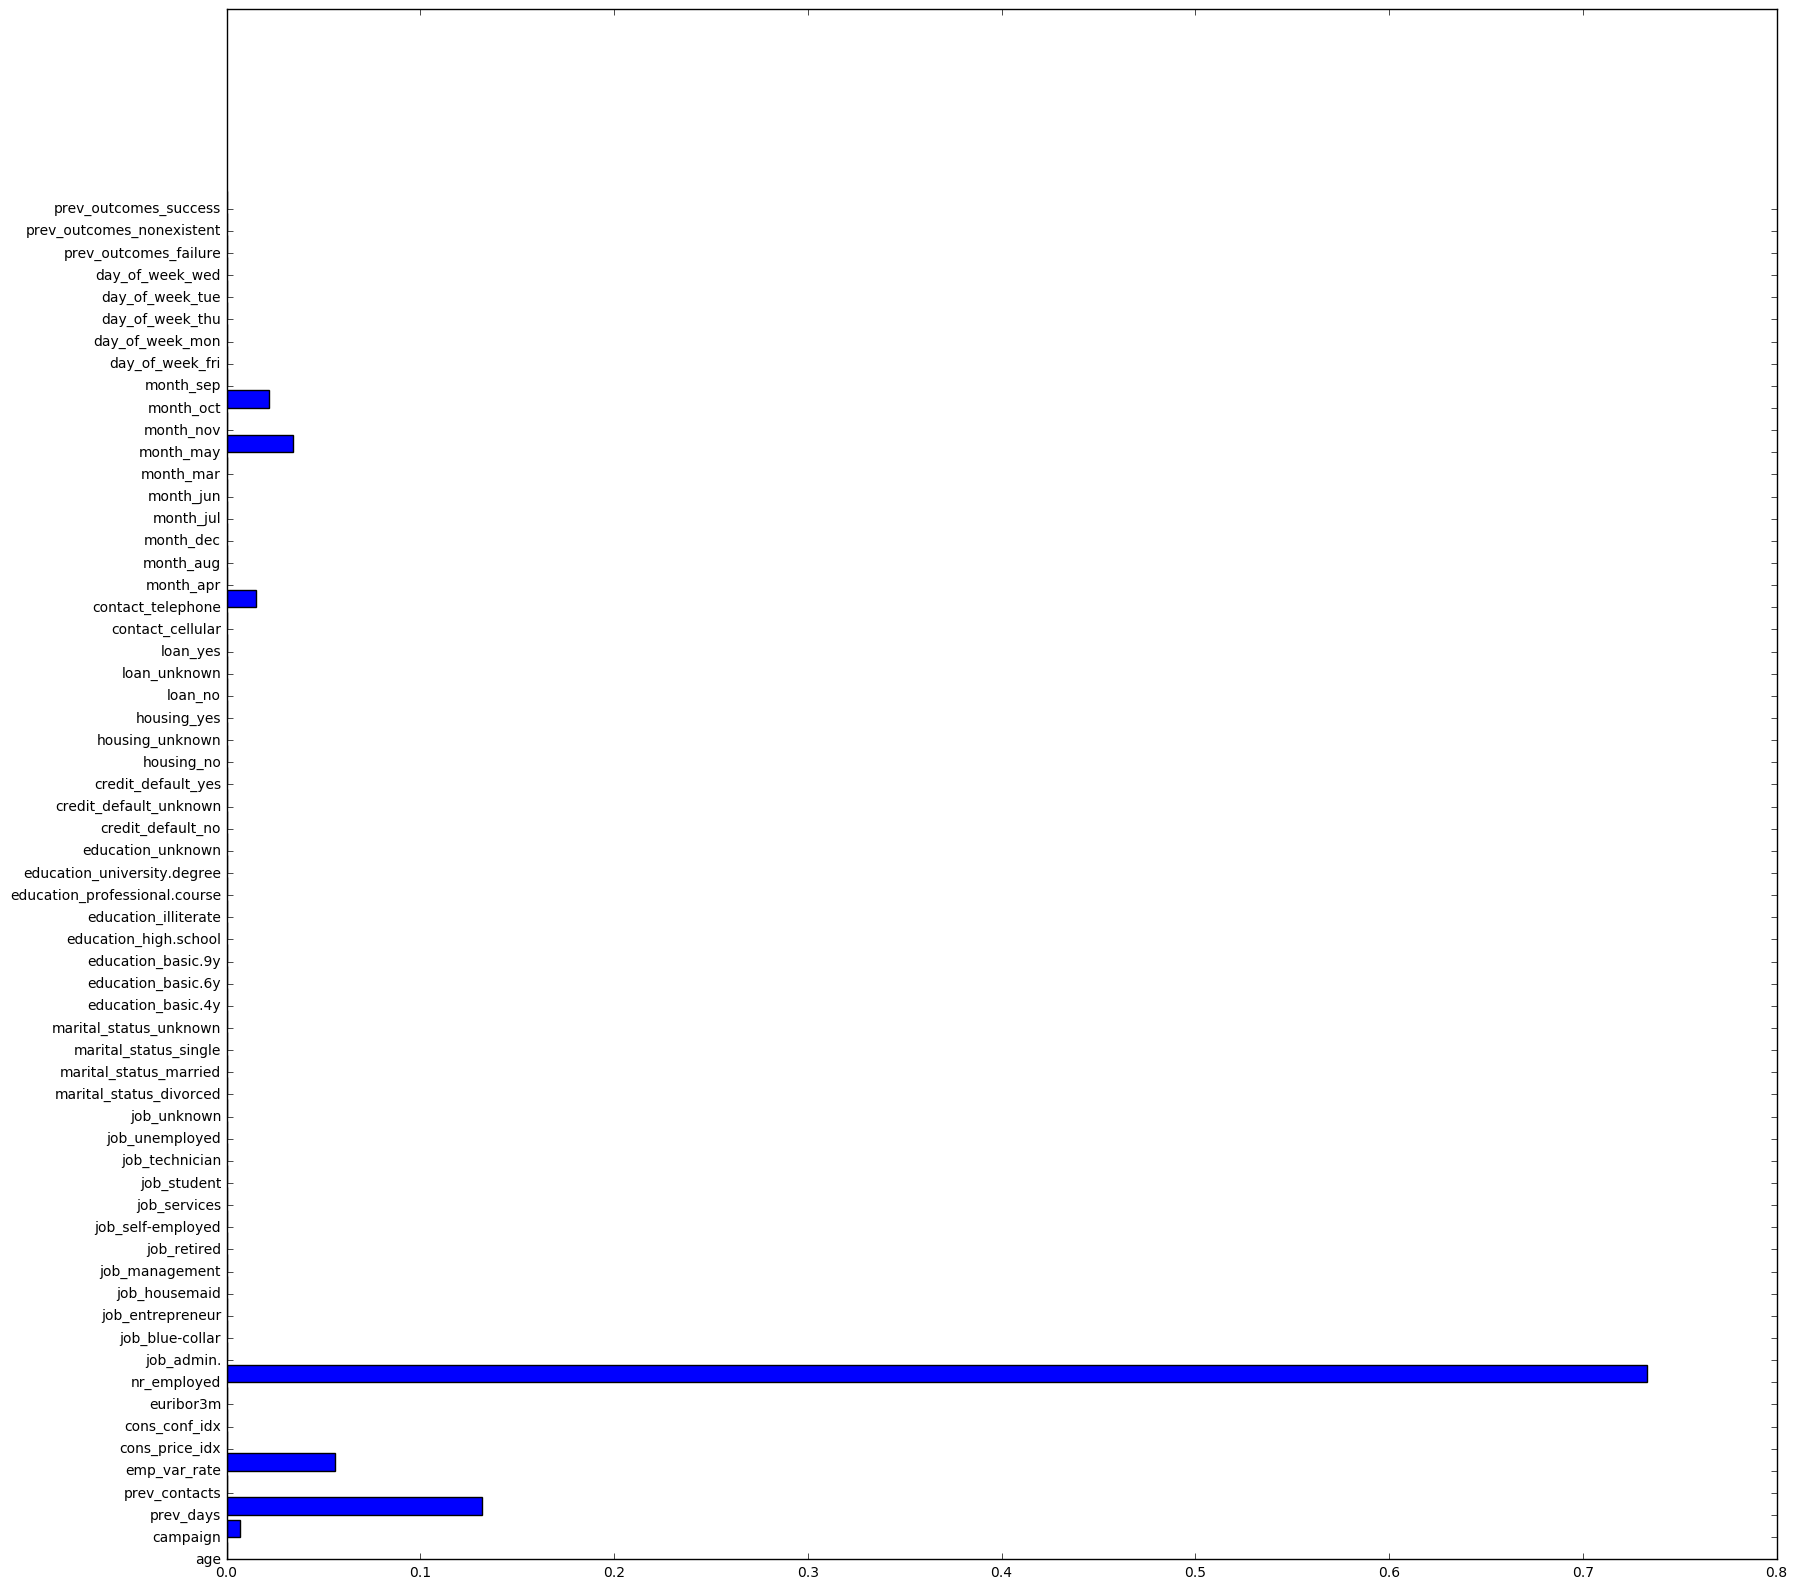

In [392]:
tree.feature_importances_
plt.figure(figsize=(20,20))
plt.barh(range(62), tree.feature_importances_)
plt.yticks(range(62), X_train.columns.values)


### Random Forest

Random forests parameters were selected by grid search. 

In [1852]:
from sklearn.ensemble import RandomForestClassifier
rf = make_pipeline(RandomForestClassifier(class_weight = 'balanced', max_features = 'auto', random_state = 42))

param_grid = {'randomforestclassifier__n_estimators': np.arange(10,300,20),
             }
grid = GridSearchCV(rf, param_grid = param_grid, cv = 5, scoring = 'roc_auc')
grid.fit(X_train,y_train)

print(grid.score(X_test,y_test))
print(grid.best_params_)
pred = grid.predict_proba(X_test)
print("ROC Score: {:.3f}".format(roc_auc_score(y_test, pred[:,1])))

0.797301025542
{'randomforestclassifier__n_estimators': 290}
ROC Score: 0.797


In [1858]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y,test_size=0.15,random_state=0)#random_state=42,test_size=0.2)

n_features=X_train.shape[1]
clf = RandomForestClassifier( oob_score=True, n_estimators=290,max_features = 'auto', random_state=0,max_depth=None, min_samples_split=3,class_weight='balanced')
scores = cross_val_score(clf, X_train, y_train)
print(scores.mean())

classifier = clf.fit(X_train,y_train)
predictions = classifier.predict_proba(X_test)
# pred_rf = rf.predict_proba(X_test)
# pred = voting.predict(X_test)
print("ROC Score: {:.3f}".format(roc_auc_score(y_test, predictions[:, 1])))

0.897275734364
ROC Score: 0.806


In [1738]:
cal_rf = CalibratedClassifierCV(clf, cv="prefit", method='sigmoid')
cal_rf.fit(X_train, y_train)
scores_sigm = cal_rf.predict_proba(X_test)[:, 1]
print("ROC Score: {:.3f}".format(roc_auc_score(y_test, scores_sigm)))
cal_rf_iso = CalibratedClassifierCV(clf, cv="prefit", method='isotonic')
cal_rf_iso.fit(X_train, y_train)
scores_iso = cal_rf_iso.predict_proba(X_test)[:, 1]
print("ROC Score: {:.3f}".format(roc_auc_score(y_test, scores_iso)))

ROC Score: 0.782
ROC Score: 0.656


In [393]:
rf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

Feature importances were plotted for random forests as well.

In [394]:
rf.feature_importances_

array([ 0.073,  0.034,  0.032,  0.013,  0.101,  0.08 ,  0.099,  0.107,
        0.117,  0.011,  0.008,  0.004,  0.003,  0.006,  0.006,  0.004,
        0.006,  0.004,  0.009,  0.003,  0.001,  0.007,  0.011,  0.01 ,
        0.001,  0.005,  0.004,  0.007,  0.01 ,  0.   ,  0.008,  0.011,
        0.005,  0.006,  0.005,  0.   ,  0.012,  0.002,  0.012,  0.008,
        0.002,  0.007,  0.007,  0.006,  0.005,  0.004,  0.001,  0.004,
        0.005,  0.006,  0.007,  0.003,  0.007,  0.003,  0.01 ,  0.01 ,
        0.011,  0.01 ,  0.01 ,  0.009,  0.008,  0.022])

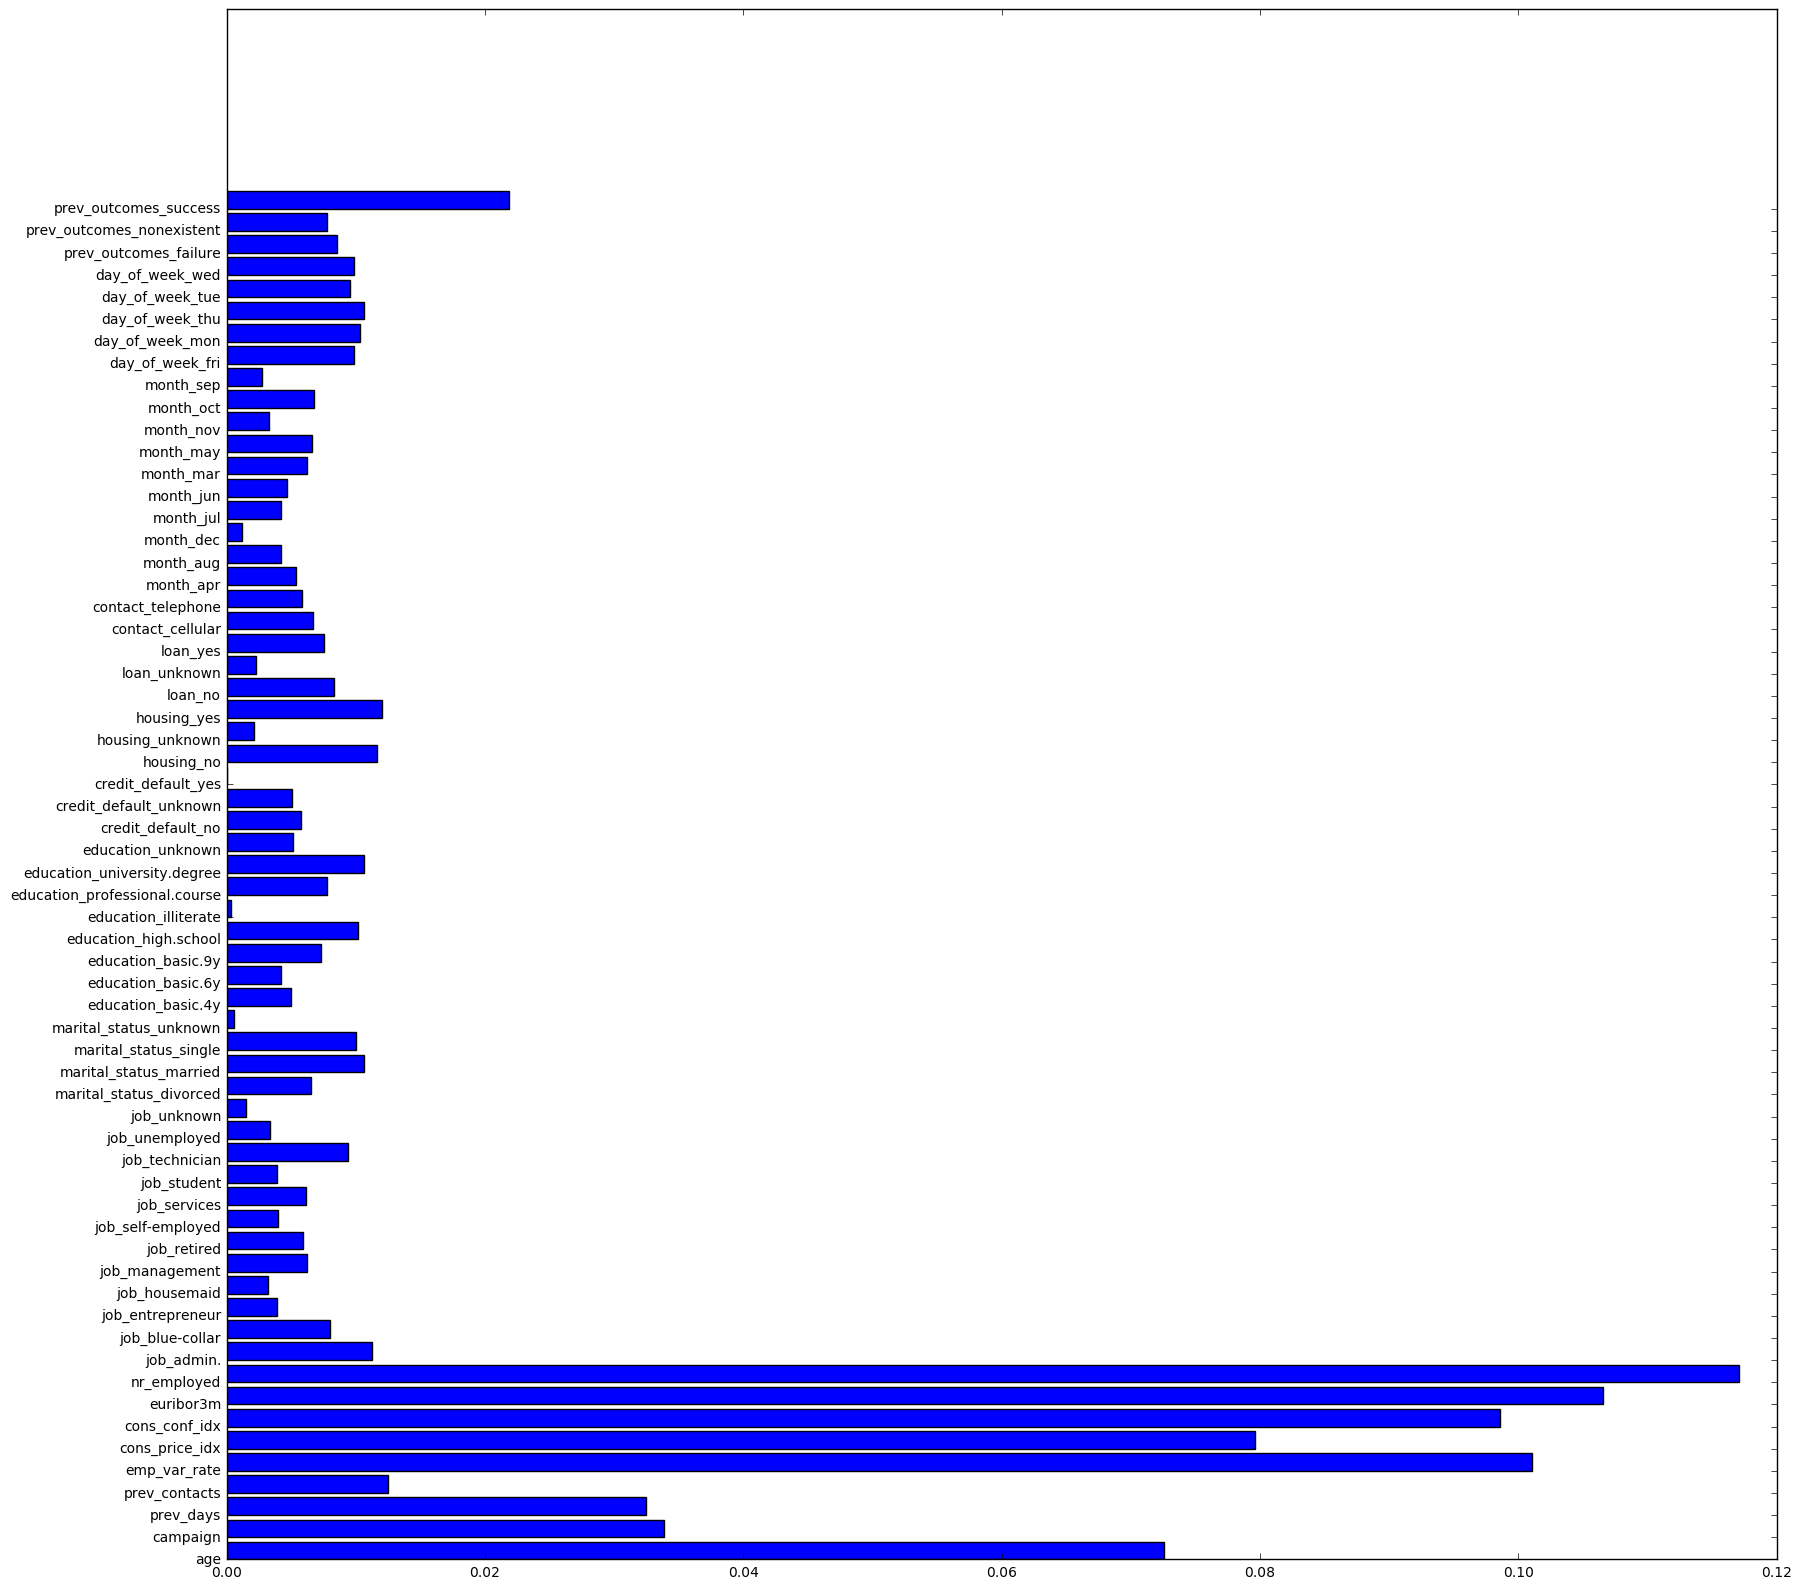

In [395]:
plt.figure(figsize=(20,20))
plt.barh(range(62), rf.feature_importances_)
plt.yticks(range(62), X_train.columns.values);

### Gradient Boosting

Gradient boosting gave the best ROC AUC scores of 82%. The parameters were learned using grid search.

In [1343]:
from sklearn.ensemble import GradientBoostingClassifier
X_train, X_test, y_train, y_test = train_test_split(
    X,y, stratify=y, random_state=0)
gbrt = GradientBoostingClassifier(learning_rate=0.05).fit(X_train, y_train)
predictions = gbrt.predict_proba(X_test)
# pred_rf = rf.predict_proba(X_test)
# pred = voting.predict(X_test)
print("ROC Score: {:.3f}".format(roc_auc_score(y_test, predictions[:, 1])))

ROC Score: 0.809


In [1396]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0,test_size=0.15)
gbrt = GradientBoostingClassifier(max_depth=3, n_estimators=300, learning_rate=.05, random_state=0).fit(X_train, y_train)
gbrt.score(X_test, y_test)
predictions = gbrt.predict_proba(X_test)
# pred_rf = rf.predict_proba(X_test)
# pred = voting.predict(X_test)
print("ROC Score: {:.3f}".format(roc_auc_score(y_test, predictions[:, 1])))

ROC Score: 0.819


In [1807]:
n_features=X_train.shape[1]
est = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05,
   max_depth=4, random_state=0,max_features=n_features).fit(X_train, y_train)
predictions = est.predict_proba(X_test)
# pred_rf = rf.predict_proba(X_test)
# pred = voting.predict(X_test)
print("ROC Score: {:.3f}".format(roc_auc_score(y_test, predictions[:, 1])))

ROC Score: 0.820


### Extra Trees Classifier

Extra Trees Classifier gave an ROC score of 82%.

In [1581]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=100, max_depth=7,
   random_state=0)
clf.fit(X_train, y_train)
predictions = clf.predict_proba(X_test)
# pred_rf = rf.predict_proba(X_test)
# pred = voting.predict(X_test)
print("ROC Score: {:.3f}".format(roc_auc_score(y_test, predictions[:, 1])))

ROC Score: 0.820


### Adaboost 

Adaboost did not perform as well as we expected.

In [1539]:
from sklearn.ensemble import AdaBoostClassifier
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                         algorithm="SAMME",
                         n_estimators=300)

bdt.fit(X_train, y_train)
predictions = bdt.predict_proba(X_test)
# pred_rf = rf.predict_proba(X_test)
# pred = voting.predict(X_test)
print("ROC Score: {:.3f}".format(roc_auc_score(y_test, predictions[:, 1])))

ROC Score: 0.813


### Neural Networks

Neural network models like MLP and Keras were used and both gave good ROC scores but could not be included in Voting classifier.

##### MLP Classifier

In [1699]:
from sklearn.neural_network import MLPClassifier
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=0,test_size=0.2)
scaler = MinMaxScaler()  
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(30,30,30), random_state=1, warm_start=True)

clf.fit(X_train, y_train) 
X_test = scaler.transform(X_test)  
y_pred = clf.predict_proba(X_test)
print(("Test Score: {:.4f} " ).format(clf.score(X_test, y_test)))
print("ROC Score: {:.3f}".format(roc_auc_score(y_test, y_pred[:,1])))

Test Score: 0.8995 
ROC Score: 0.802


In [845]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
mlp = MLPClassifier()
mlp_pipe =  make_pipeline(StandardScaler(), mlp)
cross_val_score(mlp_pipe, X_train, y_train, cv=5, scoring="roc_auc")

array([ 0.782,  0.776,  0.794,  0.784,  0.772])

In [1853]:
from sklearn.model_selection import GridSearchCV
param_grid = {'mlpclassifier__hidden_layer_sizes': [5, 10, 50, 100, 200]}
grid = GridSearchCV(mlp_pipe, param_grid, cv=5, scoring = 'roc_auc')
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('mlpclassifier', MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
 ...=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'mlpclassifier__hidden_layer_sizes': [5, 10, 50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [1854]:
print('Best mean cross val score: {:.3f} %'.format(grid.best_score_*100))
print("best parameters: {}".format(grid.best_params_))


y_pred = grid.predict_proba(X_test)
print(("Test Score: {:.4f} " ).format(grid.score(X_test, y_test)))
print("ROC Score: {:.3f}".format(roc_auc_score(y_test, y_pred[:,1])))

Best mean cross val score: 78.563 %
best parameters: {'mlpclassifier__hidden_layer_sizes': 5}
Test Score: 0.8078 
ROC Score: 0.808


##### Keras

In [1697]:
# Create your first MLP in Keras
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
model.fit(X_train, y_train, epochs=10, batch_size=10, verbose=2)
# evaluate the model
scores = model.evaluate(X_train, y_train)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
predictions = model.predict_proba(X_test)
print("")
print("ROC Score: {:.3f}".format(roc_auc_score(y_test, predictions)))

Epoch 1/10
8s - loss: 0.2909 - acc: 0.8955
Epoch 2/10
9s - loss: 0.2815 - acc: 0.8977
Epoch 3/10
7s - loss: 0.2800 - acc: 0.8983
Epoch 4/10
8s - loss: 0.2787 - acc: 0.8995
Epoch 5/10
8s - loss: 0.2776 - acc: 0.8991
Epoch 6/10
8s - loss: 0.2768 - acc: 0.8990
Epoch 7/10
8s - loss: 0.2757 - acc: 0.8997
Epoch 8/10
8s - loss: 0.2754 - acc: 0.8998
Epoch 9/10
11s - loss: 0.2748 - acc: 0.8993
Epoch 10/10
7s - loss: 0.2743 - acc: 0.9003
25024/26360 [===========================>..] - ETA: 0s
acc: 90.17%
5600/6590 [========================>.....] - ETA: 0s
ROC Score: 0.812


# Step4 - Ensemble [20 points + 10 Bonus points]

In this step, we expect you to use the models created before and create new predictions. You should definitely try poor man's stacking but we encourage you to think of different ensemble techniques as well. We will judge your creativity and improvement in model performance using ensemble models and you can potentially earn 10 bonus points here.

In [1934]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd

## Non-tree ensembles

In [1812]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0,test_size=0.15)

voting4 = VotingClassifier([('logreg', make_pipeline(MinMaxScaler(),PCA(n_components=50),LogisticRegressionCV(penalty='l2',Cs=100,class_weight = 'balanced'))),
                            ('svc',SVC(kernel = 'linear', probability = True, class_weight = 'balanced', random_state = 42)),
                          ('knn',KNeighborsClassifier(n_neighbors=13))
                          ],
                         voting='soft')
voting4.fit(X_train, y_train)

lr,svc,knn= voting4.estimators_
print(("{:.4f} " * 4).format(voting4.score(X_test, y_test),
                             lr.score(X_test, y_test), 
                             svc.score(X_test, y_test), 
                             knn.score(X_test, y_test),
                             ))


pred = voting4.predict_proba(X_test)
print("ROC Score: {:.3f}".format(roc_auc_score(y_test, pred[:,1])))

0.8903 0.8240 0.7678 0.9009 
ROC Score: 0.820


## Tree based ensembles

In [1524]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0,test_size=0.15)

# X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42,test_size=0.2)

voting = VotingClassifier([
#                             ('logreg', make_pipeline(MinMaxScaler(), LogisticRegression(penalty='l2',C=1000))),
                           ('tree', DecisionTreeClassifier(max_depth=3, random_state=0)),
                          
                           ('rf', RandomForestClassifier(n_estimators=300,class_weight='balanced')),
                           ('gbrt', GradientBoostingClassifier(learning_rate=.05)),
#                           ('knn',KNeighborsClassifier(n_neighbors=13))
                          ],
                         voting='soft')
voting.fit(X_train, y_train)

lr,rf,gbrt= voting.estimators_ced
print(("{:.4f} " * 4).format(voting.score(X_test, y_test),
                             lr.score(X_test, y_test), 
                             rf.score(X_test, y_test),
                             gbrt.score(X_test, y_test),
                             ))
# lr, tree, rf,gbrt, knn = voting.estimators_
# print(("{:.4f} " * 6).format(voting.score(X_test, y_test),
#                              lr.score(X_test, y_test), tree.score(X_test, y_test), rf.score(X_test, y_test),
#                              gbrt.score(X_test, y_test),
#                              knn.score(X_test, y_test)))

pred = voting.predict_proba(X_test)
# pred = voting.predict(X_test)
print("ROC Score: {:.3f}".format(roc_auc_score(y_test, pred[:,1])))
# print("Confusion matrix:\n{}".format(confusion_matrix(y_test, pred)))
# roc_auc_score(y_true, y_scores)

0.9015 0.9021 0.9011 
ROC Score: 0.821


## Best Mixed ensemble


In [1856]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0,test_size=0.15)

# X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42,test_size=0.2)

voting6 = VotingClassifier([('logreg', make_pipeline(MinMaxScaler(),PCA(n_components=50),LogisticRegressionCV(penalty='l2',Cs=100,class_weight = 'balanced'))),
#                            ('tree', DecisionTreeClassifier(max_depth=3, random_state=0)),
#                            ('rf', RandomForestClassifier(n_estimators=200)),
                           ('gbrt', GradientBoostingClassifier(max_depth=3, n_estimators=300, learning_rate=.05, random_state=0)),
#                           ('knn',KNeighborsClassifier(n_neighbors=13))
                          ],
                         voting='soft')
voting6.fit(X, y)

lr,gbrt= voting6.estimators_
print(("{:.4f} " * 3).format(voting6.score(X_test, y_test),
                             lr.score(X_test, y_test),
#                              k.score(X_test, y_test),
#                              tree.score(X_test, y_test),
                             gbrt.score(X_test, y_test),
                             ))
# lr, tree, rf,gbrt, knn = voting.estimators_
# print(("{:.4f} " * 6).format(voting.score(X_test, y_test),
#                              lr.score(X_test, y_test), tree.score(X_test, y_test), rf.score(X_test, y_test),
#                              gbrt.score(X_test, y_test),
#                              knn.score(X_test, y_test)))

pred = voting6.predict_proba(X_test)
# pred = voting.predict(X_test)
print("ROC Score: {:.3f}".format(roc_auc_score(y_test, pred[:,1])))
# print("Confusion matrix:\n{}".format(confusion_matrix(y_test, pred)))
# roc_auc_score(y_true, y_scores)

0.8889 0.8250 0.9112 
ROC Score: 0.829


## Stacking Classifier

Stacking classifer from the mlxtend package was used to combine multiple classification models via a meta-classifier. This model ensures that individual classification models are trained based on the complete training set; then, the meta-classifier is fitted based on the outputs -- meta-features -- of the individual classification models in the ensemble. The meta-classifier is then trained on the predicted class probabilities from the ensemble. In this case Gradient Boosting Classifier was used and logistic regression was used as meta-classifier. AN ROC AUC score of 81.9% was achieved.



In [1869]:
from mlxtend.classifier import StackingClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0,test_size=0.15)

# X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42,test_size=0.2)

clf1 = GradientBoostingClassifier(max_depth=3, n_estimators=300, learning_rate=.05, random_state=0)
# clf2 = RandomForestClassifier( oob_score=True, n_estimators=290,max_features = 'auto', random_state=0,max_depth=None, min_samples_split=3,class_weight='balanced')
# clf3 = GaussianNB()
lr = make_pipeline(MinMaxScaler(),LogisticRegressionCV(penalty='l2',Cs=100,class_weight = 'balanced'))

sclf = StackingClassifier(classifiers=[clf1], 
                          use_probas=True,
                          average_probas=False,

                          meta_classifier=lr)
# scores = model_selection.cross_val_score(clf, X, y, 
#                                               cv=3, scoring='roc_auc')


# voting6 = VotingClassifier([('logreg', make_pipeline(MinMaxScaler(),PCA(n_components=50),LogisticRegressionCV(penalty='l2',Cs=100,class_weight = 'balanced'))),
# #                            ('tree', DecisionTreeClassifier(max_depth=3, random_state=0)),
# #                            ('rf', RandomForestClassifier(n_estimators=200)),
#                            ('gbrt', GradientBoostingClassifier(max_depth=3, n_estimators=300, learning_rate=.05, random_state=0)),
# #                           ('knn',KNeighborsClassifier(n_neighbors=13))
#                           ],
#                          voting='soft')
sclf.fit(X_train, y_train)

# lr,gbrt= voting6.estimators_
# print(("{:.4f} " * 3).format(voting6.score(X_test, y_test),
#                              lr.score(X_test, y_test),
# #                              k.score(X_test, y_test),
# #                              tree.score(X_test, y_test),
#                              gbrt.score(X_test, y_test),
#                              ))
# # lr, tree, rf,gbrt, knn = voting.estimators_
# # print(("{:.4f} " * 6).format(voting.score(X_test, y_test),
#                              lr.score(X_test, y_test), tree.score(X_test, y_test), rf.score(X_test, y_test),
#                              gbrt.score(X_test, y_test),
#                              knn.score(X_test, y_test)))

pred = sclf.predict_proba(X_test)
# pred = voting.predict(X_test)
print("ROC Score: {:.3f}".format(roc_auc_score(y_test, pred[:,1])))
# print("Confusion matrix:\n{}".format(confusion_matrix(y_test, pred)))
# roc_auc_score(y_true, y_scores)

ROC Score: 0.819


### Resampling Technique and Easy ensemble

### Undersampler and Oversampler

In order to account for class imbalance, we set the class_weight parameter as balanced in our models. This adjusts the loss function in a manner similar to oversampling. Other techniques for undersampling and oversampling fom the imblearn package were tried on the dataset but did not improve ROC AUC scores any further.

In [1878]:
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.under_sampling import RandomUnderSampler

undersample_pipe = make_imb_pipeline(RandomUnderSampler(), MinMaxScaler(),LogisticRegressionCV(penalty='l2',Cs=100,class_weight = 'balanced'))
scores = cross_val_score(undersample_pipe, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))
undersample_pipe.fit(X_train, y_train)
pred = undersample_pipe.predict_proba(X_test)
print("ROC Score: {:.3f}".format(roc_auc_score(y_test, pred[:,1])))

0.783893049423
ROC Score: 0.816


In [1897]:
from imblearn.over_sampling import RandomOverSampler
oversample_pipe = make_imb_pipeline(RandomOverSampler(), LogisticRegressionCV())
scores = cross_val_score(oversample_pipe, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))
oversample_pipe.fit(X_train, y_train)
pred = oversample_pipe.predict_proba(X_test)
print("ROC Score: {:.3f}".format(roc_auc_score(y_test, pred[:,1])))

0.781985487351
ROC Score: 0.814


### SMOTE

The SMOTE technique from the imblearn package was tried as well for both logistic regression and random forests. Again this did not give any further increase in score over what we already achieved with existing models and hence was not used in the final ensemble.

In [1890]:
from imblearn.over_sampling import SMOTE
smote_pipe = make_imb_pipeline(SMOTE(), LogisticRegressionCV())
scores = cross_val_score(smote_pipe, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))
smote_pipe.fit(X_train, y_train)
pred = smote_pipe.predict_proba(X_test)
print("ROC Score: {:.3f}".format(roc_auc_score(y_test, pred[:,1])))

0.781217244599
ROC Score: 0.814


In [1891]:
smote_pipe_rf = make_imb_pipeline(SMOTE(k_neighbors=11), RandomForestClassifier(n_estimators=100))
scores = cross_val_score(smote_pipe_rf, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))
smote_pipe_rf.fit(X_train, y_train)
pred = smote_pipe_rf.predict_proba(X_test)
print("ROC Score: {:.3f}".format(roc_auc_score(y_test, pred[:,1])))

0.773378258543
ROC Score: 0.790


### Quick and Dirty Easy Ensemble

A basic easy ensembling technique was applied to make a resampled ensemble model for decision trees and logistic regression. Both gave good ROC AUC scores of over 80%.

In [1900]:
from sklearn.base import clone

def make_resampled_ensemble(estimator, n_estimators=100):
    estimators = []
    for i in range(n_estimators):
        est = clone(estimator)
        if hasattr(est, "random_state"):
            est.random_state = i
        pipe = make_imb_pipeline(RandomUnderSampler(random_state=i, replacement=True),
                                 est)
        estimators.append(("est_i".format(i), pipe))
    return VotingClassifier(estimators, voting="soft")

In [1902]:
resampled_tree_test = make_resampled_ensemble(DecisionTreeClassifier(max_features='auto'))

scores = cross_val_score(resampled_tree_test, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))
resampled_tree_test.fit(X_train, y_train)
pred = resampled_tree_test.predict_proba(X_test)
print("ROC Score: {:.3f}".format(roc_auc_score(y_test, pred[:,1])))

0.785869762995
ROC Score: 0.808


In [1905]:
resampled_lr = make_resampled_ensemble(LogisticRegressionCV())

scores = cross_val_score(resampled_lr, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))
resampled_lr.fit(X_train, y_train)
pred = resampled_lr.predict_proba(X_test)
print("ROC Score: {:.3f}".format(roc_auc_score(y_test, pred[:,1])))

0.782603506427
ROC Score: 0.814


## Holdout Set

Predictions for the leaderboard were generated by training the final models on the entire dataset and then predicting against the holdout set. The holdout datset was first preprocessed in a similar manner as data. ID and duration columns were dropped. After dummy creation, credit_default_yes column was missing so this was added manually and set to 0 for all the records. Final models were used for prediction. 

In [1705]:
 #write code below, you can make multiple cells
hold = pd.read_csv("data/holdout.csv")
hold.shape

(8238, 21)

In [1706]:
hold

,ID,age,job,marital_status,education,credit_default,housing,loan,contact,month,...,duration,campaign,prev_days,prev_contacts,prev_outcomes,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
0,2866,47.0,admin.,divorced,university.degree,unknown,no,no,telephone,may,...,239.0,2.0,999,0,nonexistent,1.247123,92.972198,-35.612530,4.932103,5190.0
1,1957,40.0,blue-collar,married,basic.4y,unknown,no,no,telephone,jun,...,297.0,5.0,999,0,nonexistent,1.336096,95.085866,-40.841331,5.082825,5225.0
2,768,42.0,technician,married,professional.course,no,yes,no,cellular,jul,...,415.0,3.0,999,0,nonexistent,1.388607,93.705043,-42.039772,4.941916,5232.0
3,4510,53.0,blue-collar,divorced,basic.4y,unknown,yes,no,telephone,may,...,386.0,1.0,999,0,nonexistent,1.146340,92.826786,-36.824117,4.916084,5205.0
4,7893,54.0,self-employed,married,high.school,no,yes,no,cellular,aug,...,2.0,6.0,999,0,nonexistent,1.490160,94.392184,-36.710934,4.999765,5226.0
5,5540,34.0,admin.,single,university.degree,unknown,yes,no,cellular,jul,...,106.0,2.0,999,0,nonexistent,1.426098,93.677214,-42.131346,4.929474,5233.0
6,385,31.0,admin.,single,basic.6y,no,no,no,cellular,apr,...,170.0,2.0,999,0,nonexistent,-1.706281,93.015086,-47.054410,1.313387,5105.0
7,5152,22.0,technician,single,high.school,no,yes,no,cellular,jul,...,377.0,3.0,999,0,nonexistent,1.574322,94.602336,-43.178295,4.820545,5233.0
8,1770,26.0,admin.,married,university.degree,no,no,yes,telephone,jun,...,76.0,3.0,999,0,nonexistent,1.347172,93.745585,-41.889335,4.958583,5222.0
9,5779,47.0,management,married,high.school,no,no,no,telephone,may,...,25.0,1.0,999,0,nonexistent,1.051346,92.246031,-37.425973,4.915431,5194.0


In [1707]:
h1=hold.drop(["ID","duration"],axis=1)
# h1=hold.drop(["ID"],axis=1)
# hold.drop(hold.columns[["ID","duration"]], axis=1, inplace=True)
h1.shape

(8238, 19)

In [1710]:
hold_dummy = pd.get_dummies(h1, columns = cat_col)
hold_dummy.shape

(8238, 61)

In [1644]:
tr=list(X.columns.values)
len(tr)

63

In [1645]:
ho=list(hold_dummy.columns.values)
len(ho)

62

In [1646]:
uniq=list(set(X)-set(hold_dummy))
uniq

['credit_default_yes']

In [1711]:
hold_dummy.insert(35, 'credit_default_yes', 0)

In [1140]:
hold_dummy

,age,duration,campaign,prev_days,prev_contacts,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,prev_outcomes_failure,prev_outcomes_nonexistent,prev_outcomes_success
0,47.0,239.0,2.0,999,0,1.247123,92.972198,-35.612530,4.932103,5190.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,40.0,297.0,5.0,999,0,1.336096,95.085866,-40.841331,5.082825,5225.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,42.0,415.0,3.0,999,0,1.388607,93.705043,-42.039772,4.941916,5232.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,53.0,386.0,1.0,999,0,1.146340,92.826786,-36.824117,4.916084,5205.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,54.0,2.0,6.0,999,0,1.490160,94.392184,-36.710934,4.999765,5226.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,34.0,106.0,2.0,999,0,1.426098,93.677214,-42.131346,4.929474,5233.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,31.0,170.0,2.0,999,0,-1.706281,93.015086,-47.054410,1.313387,5105.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7,22.0,377.0,3.0,999,0,1.574322,94.602336,-43.178295,4.820545,5233.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
8,26.0,76.0,3.0,999,0,1.347172,93.745585,-41.889335,4.958583,5222.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,47.0,25.0,1.0,999,0,1.051346,92.246031,-37.425973,4.915431,5194.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [1712]:
hold_dummy.shape

(8238, 62)

In [1713]:
X.columns.values

array(['age', 'campaign', 'prev_days', 'prev_contacts', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_status_divorced', 'marital_status_married',
       'marital_status_single', 'marital_status_unknown',
       'education_basic.4y', 'education_basic.6y', 'education_basic.9y',
       'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'credit_default_no', 'credit_default_unknown',
       'credit_default_yes', 'housing_no', 'housing_unknown',
       'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_jul', '

In [1714]:
hold_dummy.columns.values

array(['age', 'campaign', 'prev_days', 'prev_contacts', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_status_divorced', 'marital_status_married',
       'marital_status_single', 'marital_status_unknown',
       'education_basic.4y', 'education_basic.6y', 'education_basic.9y',
       'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'credit_default_no', 'credit_default_unknown',
       'credit_default_yes', 'housing_no', 'housing_unknown',
       'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_jul', '

In [1886]:
predictions_hold = undersample_pipe.predict_proba(hold_dummy)
predictions_hold

array([[ 0.8  ,  0.2  ],
       [ 0.835,  0.165],
       [ 0.635,  0.365],
       ..., 
       [ 0.617,  0.383],
       [ 0.692,  0.308],
       [ 0.583,  0.417]])

In [1887]:
ids=hold["ID"]
ids.shape
res=pd.DataFrame(predictions_hold[:,1])
res = res.rename(columns={0: 'subscribed'})
res

,subscribed
0,0.199632
1,0.165299
2,0.365133
3,0.150714
4,0.260044
5,0.357564
6,0.595742
7,0.314074
8,0.322028
9,0.207582


In [1888]:
final = pd.concat([ids, res], axis=1)
final

,ID,subscribed
0,2866,0.199632
1,1957,0.165299
2,768,0.365133
3,4510,0.150714
4,7893,0.260044
5,5540,0.357564
6,385,0.595742
7,5152,0.314074
8,1770,0.322028
9,5779,0.207582


In [1889]:
final.to_csv('finaltoupload_now27.csv', sep=',',index =False)

In [1906]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd

def predict2():
    df = pd.read_csv("data/data.csv")
    df=df.drop("duration",axis=1)
    df_sub = pd.get_dummies(df['subscribed'])
    df_new=pd.concat([df, df_sub], axis=1)
    df_new=df_new.drop("subscribed", axis=1)
    df_new=df_new.drop("no", axis=1)
    df_new["yes"]=df_new["yes"].apply(int)
    df_new = df_new.rename(columns={'yes': 'subscribed'})
    y=df_new.subscribed
    X_drop=df_new.drop("subscribed", axis=1)
    cat_col=["job","marital_status","education","credit_default","housing","loan","contact","month","day_of_week","prev_outcomes"]
    X = pd.get_dummies(X_drop, columns = cat_col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0,test_size=0.15)

    voting6 = VotingClassifier([('logreg', make_pipeline(MinMaxScaler(),PCA(n_components=50),LogisticRegressionCV(penalty='l2',Cs=100,class_weight = 'balanced'))),
                           ('gbrt', GradientBoostingClassifier(max_depth=3, n_estimators=300, learning_rate=.05, random_state=0)),
                          ],
                         voting='soft')
    voting6.fit(X, y)

    lr,gbrt= voting6.estimators_
    print(("{:.4f} " * 3).format(voting6.score(X_test, y_test),
                             lr.score(X_test, y_test),
                             gbrt.score(X_test, y_test),
                             ))
    pred = voting6.predict_proba(X_test)
    print("ROC Score: {:.3f}".format(roc_auc_score(y_test, pred[:,1])))
    return roc_auc_score(y_test, pred[:,1])

p=predict2()
assert p > 0.82

0.8889 0.8250 0.9112 
ROC Score: 0.829


The final ROC AUC scores were calculated and tested against using assert statements. The final models and their ROC AUC is given below:

 - Ensemble of non-tree models (logistic regression, knn, svm with linear kernel) : 82.0%
 - Ensemble of tree based models (gradient boosting classifier, random forest, decision tree) : 82.1%
 - Mixed ensemble model ( logistic regression, gradient boosting classifier) : 82.9%